# Test of General Relativity via Gravitaional-Wave Radiation

We first import the necessary packages.

In [28]:
#Here the necessary packages are installed
import datetime
#import pylab
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import Locator
from scipy.interpolate import interpn
import numpy as np
import collections
from more_itertools import collapse
import statistics as st
from scipy.stats import norm
from scipy import optimize
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit
import lalsimulation
import cmath
import math
from shapely.geometry import LineString
from scipy.integrate import quad, simps, cumtrapz, romb
from numpy import diff, gradient
from pycbc import pnutils
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.waveform.utils import amplitude_from_frequencyseries, phase_from_frequencyseries, frequency_from_polarizations
from pycbc.waveform.waveform import get_fd_waveform_from_td
st = datetime.datetime.now()

After importing the necessary packages, we define the fundamental constants and some of the initial parameters.

In [29]:
#Here the fundamental constants are defined
G = 6.6743015e-11
c = 299792458
M_sun = 1.989e+30 
#Here we set the luminosity distance
r = 410.0 #Luminosity distance in megaparsecs
L = r*3.086e+22 #luminosity distance in SI units

We now define a function that gives the time and frequency arrays for a GW signature.

In [66]:
#Here we write a function to output the time array
def t(**kwargs):
    hp, hc = get_td_waveform(approximant="IMRPhenomPv2",
                                   delta_t=1.0/4096,
                                   inclination=0,
                                   coa_phase=0,
                                   distance=r,
                                   **kwargs)
    return hp.sample_times
#Here we write a function to output the frequency array
def freq(**kwargs):
    hp_3, hc_3 = get_td_waveform(approximant="IMRPhenomPv2",
                                 delta_t=1.0/4096,
                                 inclination=0,
                                 coa_phase=0,
                                 distance=r,
                                 **kwargs)
    GW_freq = frequency_from_polarizations(hp_3, hc_3)
    return GW_freq

Simultaneously, we can get the dimensionless GW strain for the "$+$"- and "$\times$"-polarizations for different $\theta$ and $\phi$.

In [67]:
#Here we write a function to output the dimensionless strain 
#Let the hp_1 and hc_1 be the plus and cross polarization at $\theta=0$ and $\phi=0$   
def h_1(**kwargs):
    hp_1, hc_1 = get_td_waveform(approximant="IMRPhenomPv2",
                                   delta_t=1.0/4096,
                                   inclination=0,
                                   coa_phase=0,
                                   distance=r,
                                   **kwargs)
    return hp_1-1j*hc_1
#Let the hp_2 and hc_2 be the plus and cross polarization at $\theta=\pi$ and $\phi=0$  
def h_2(**kwargs):
    hp_2, hc_2 = get_td_waveform(approximant="IMRPhenomPv2",
                                   delta_t=1.0/4096,
                                   inclination=np.pi,
                                   coa_phase=0,
                                   distance=r,
                                   **kwargs)
    return hp_2-1j*hc_2

Afterwards, we can write the $h_{22}$ and $h_{2-2}$ GW modes in terms of the "$+$"- and "$\times$"-polarizations.

In [68]:
#For convenience we define the following parameters
Y = np.sqrt(5/(4*np.pi))
    
#By setting $\theta=\phi=0$ and $\theta=\pi$, $\phi=0$, h_{22} and h_{2-2} are simply h_1 and h_2 divided by Y
def h_22(**kwargs):
    return h_1(**kwargs)/Y
    
def h_2minus2(**kwargs):
    return h_2(**kwargs)/Y

Now, we write a set of lists to store the GW energy with modified dephasing coefficients.

In [69]:
points_dchi = 21
    
dchi_i1 = np.linspace(-5, 5, num=points_dchi)      
dchi_i2 = np.linspace(-5, 5, num=points_dchi)      
  
time = []
f = []
t_high_list = []
t_low_list = []
h_22_list = []
h_2minus2_list = []

dchi_4 = []
dchi_5 = []

dh_22_dt = []
dh_2minus2_dt = []
dE_dt = []
E = []
peak_energy = []
E_minus_E_0 = []

Here, we write a double for loop to append the necessary data.

In [70]:
for i in range(0,points_dchi):
    time.append([])
    f.append([])
    t_high_list.append([])
    t_low_list.append([])
    h_22_list.append([])
    h_2minus2_list.append([])
    dchi_5.append(np.full(points_dchi,dchi_i2[i]))
    dchi_4.append(dchi_i1)
    dh_22_dt.append([])
    dh_2minus2_dt.append([])
    dE_dt.append([])
    E.append([])
    peak_energy.append([])
    E_minus_E_0.append([])   
    for j in dchi_i1:
        k = 1
        M_tot = 120
        m1 = M_tot*k/(1+k)
        m2 = M_tot/(1+k) 
        Mf_low=0.004
        f_low = (Mf_low/(m1+m2))/4.9268590524283380365364622010990643101143620971335214614584e-6
        Mf_high = 0.018
        f_high = (Mf_high/(m1+m2))/4.9268590524283380365364622010990643101143620971335214614584e-6
        f[i].append(freq(dchi4=j, dchi6l=dchi_5[i][0], mass1=m1, mass2=m2, spin1z=0, spin2z=0, f_lower=f_low))
        time[i].append(t(dchi4=j, dchi6l=dchi_5[i][0], mass1=m1, mass2=m2, spin1z=0, spin2z=0, f_lower=f_low))
        h_22_list[i].append(h_22(dchi4=j, dchi6=dchi_5[i][0], mass1=m1, mass2=m2, spin1z=0, spin2z=0, f_lower=f_low))
        h_2minus2_list[i].append(h_2minus2(dchi4=j, dchi6=dchi_5[i][0], mass1=m1, mass2=m2, spin1z=0, spin2z=0, f_lower=f_low))
    for j in range(0,points_dchi):
        t_m_0_index =  np.argmin(np.absolute(time[i][j]))
        t_high_index = np.absolute(f[i][j][5000:t_m_0_index]-f_high)
        t_low_index = np.absolute(f[i][j][round(0.5*len(f[i][j])):t_m_0_index]-f_low)
        t_high = np.argmin(t_high_index+5000)
        t_low = np.argmin(t_low_index+round(0.5*len(f[i][j])))
        dh_22_dt[i].append(np.gradient(h_22_list[i][j], time[i][j]))
        dh_2minus2_dt[i].append(np.gradient(h_2minus2_list[i][j], time[i][j]))
        dE_dt[i].append((c**3/(16*np.pi*G))*((np.absolute(dh_22_dt[i][j])**2+np.absolute(dh_2minus2_dt[i][j])**2)+(1/6)*(dh_22_dt[i][j]*np.conjugate(dh_2minus2_dt[i][j])+dh_2minus2_dt[i][j]*np.conjugate(dh_22_dt[i][j]))))
        E[i].append((L**2)*(1/(1.7876241e+47))*cumtrapz(dE_dt[i][j], time[i][j], initial=0))
        peak_energy[i].append(np.max(E[i][j][t_low:t_high]))

/tmp/ipykernel_3543/1206768470.py:50: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  E[i].append((L**2)*(1/(1.7876241e+47))*cumtrapz(dE_dt[i][j], time[i][j], initial=0))


Now, we extract the peak energy, and calculate the energy deviation from standard general relativity (GR). That is, GR without any phasing.

In [71]:
peak_energy_GR = peak_energy[int(0.5*(points_dchi-1))][int(0.5*(points_dchi-1))]

for i in range(0,points_dchi):
    for k in range(0,points_dchi):
        E_minus_E_0[i].append((peak_energy[i][k]-peak_energy_GR)/peak_energy_GR)

To produce the contour plot with vector fields, we need to flatten the necessary arrays.

In [80]:
def flatten(l):
    for el in l:
        if isinstance(el, collections.abc.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el

dchi_4 = list(flatten(dchi_4))
dchi_5 = list(flatten(dchi_5))
E_minus_E_0 = list(flatten(E_minus_E_0))
E_minus_E_0 = [float(x) for x in E_minus_E_0]

Now, we output the magnitude and direction of the vectors in the vector fields and normalize each vector.

In [81]:
px, ix = np.unique(dchi_4, return_inverse=True)
py, iy = np.unique(dchi_5, return_inverse=True)

points = (px, py)
  
values = np.empty_like(E_minus_E_0, shape=(px.size, py.size))
values[ix, iy] = E_minus_E_0

delta_chi_4_input , delta_chi_5_input = np.mgrid[-5:5:25*1j,-5:5:25*1j]
  
request = (delta_chi_4_input, delta_chi_5_input)
output = interpn(points, values, request)


dzdx = np.gradient(output)[0]

dzdy = np.gradient(output)[1]

average_x_direction = np.mean(dzdx)

average_y_direction = np.mean(dzdy)

average_magnitude = np.sqrt(average_x_direction**2+average_y_direction**2)

normalized_average_x_direction = average_x_direction/average_magnitude

normalized_average_y_direction = average_y_direction/average_magnitude

Plotting this on a contour plot yields.

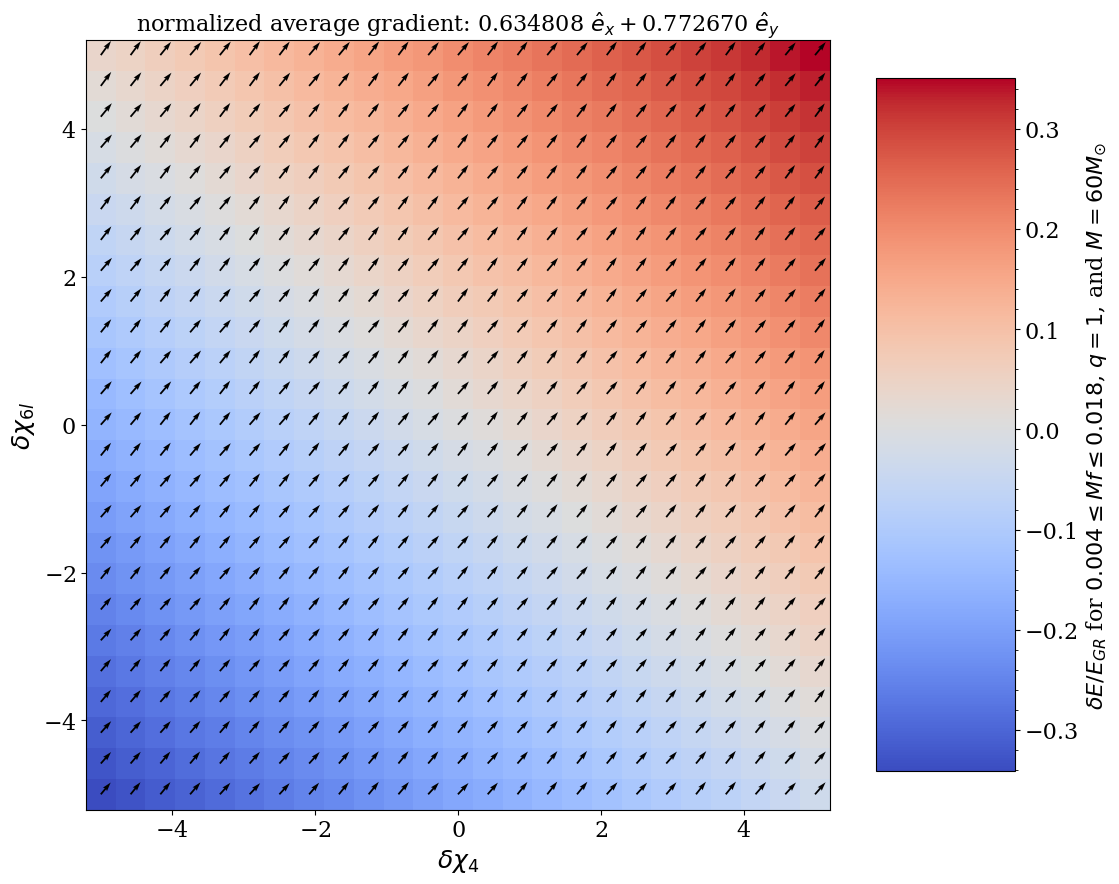

In [111]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["figure.figsize"] = (12, 10)
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)   # fontsize of the tick labels
plt.rc('ytick', labelsize=16)   # fontsize of the tick labels

fig = plt.figure()
ax = fig.add_subplot(111)

plot=ax.pcolormesh(delta_chi_4_input, delta_chi_5_input, output, cmap='coolwarm')
plt.quiver(delta_chi_4_input, delta_chi_5_input, dzdx, dzdy)

if normalized_average_x_direction>0 and normalized_average_y_direction>0:
    ax.set_title('normalized average gradient: %f $\hat{e}_x+$%f $\hat{e}_y$' % (np.abs(normalized_average_x_direction), np.abs(normalized_average_y_direction)))
elif normalized_average_x_direction<0 and normalized_average_y_direction<0:
    ax.set_title('normalized average gradient: $-$%f $\hat{e}_x-$%f $\hat{e}_y$' % (np.abs(normalized_average_x_direction), np.abs(normalized_average_y_direction)))
elif normalized_average_x_direction>0 and normalized_average_y_direction<0:
    ax.set_title('normalized average gradient: %f $\hat{e}_x-$%f $\hat{e}_y$' % (np.abs(normalized_average_x_direction), np.abs(normalized_average_y_direction)))
elif normalized_average_x_direction<0 and normalized_average_y_direction>0:
    ax.set_title('normalized average gradient: $-$%f $\hat{e}_x+$%f $\hat{e}_y$' % (np.abs(normalized_average_x_direction), np.abs(normalized_average_y_direction)))

ax.set_xlabel(r'$\delta\chi_4$', fontsize=18)
ax.set_ylabel(r'$\delta\chi_{6l}$', fontsize=18)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
#Setting color bar
cbar=fig.colorbar(plot, shrink=0.9, aspect=5, pad=0.05,label = '$\delta E/E_{GR}$ for $0.004\leq Mf \leq 0.018$, $q=1$, and $M=60M_{\odot}$')
#cbar.set_ticks([-0.72, 0, 1.00])
cbar.ax.minorticks_on()

### -End of Jupyter Notebook-